In [2]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# REST


Web services are increasingly implementing the REST (REpresentational State Transfer) architecture for developers to access their data. These include social media platforms like Twitter and Instagram, music apps like Spotify, real estate apps like Zillow, scientific sources of data such as the Climate Data Store, government data at the World Bank, and many many more. The basic idea behind REST is that every URL identifies a resource (data).


REST is stateless, meaning that the server does not remember the client from
one request to the next. This aspect of REST has a few advantages: the server
and the client can understand any message received without seeing previous
messages; code can be changed on either the client or server side without
impacting the operation of the service; and access is scalable, fast, modular,
and independent.

In this section, we work through an example to retrieve data from Spotify.


## Example: Retrieving Info on Clash Songs from Spotify

Our example follows [Steven Morse's blog post](https://stmorse.github.io/journal/spotify-api.html), where we
use both POST and GET methods in a series of requests to retrieve data on songs by [The Clash](https://www.theclash.com/).


:::{note}

In practice, we wouldn't write GET and POST requests ourselves for Spotify.
Instead, we'd use the [`spotipy`](https://spotipy.readthedocs.io/en/2.22.1/)
library, which has functions to interact with the [Spotify Web
API](https://developer.spotify.com/). That said, data scientists can often find
themselves in the position of wanting to access data available via REST that
doesn't have a Python library available, so this section shows how to get data
from a RESTful website like Spotify. 

:::


Typically a REST application provides documentation with examples on how to request their data. Spotify has extensive documentation geared to developers who want to build an app, but we can also access their service just to explore data. To do that, we need to register as a developer and get a client ID and secret. We then use these to identify us to Spotify in our HTTP requests.

After we register, we can begin to request data. There are basically two steps in this process: authenticate and request resources.

To authenticate, we issue a POST request, where we give the web service our client ID and secret. We provide these in the header of the request. In return, we receive a token from the server that authorizes us to make requests.


We begin the process and authenticate:


In [23]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

In [26]:
import requests
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

We provided our ID and secret in key:value pairs in the header of our POST request. We can check the status of our request to see if it was successful:


In [27]:
auth_response.status_code

200

And, let's check the type of content in the body of the response:


In [28]:
auth_response.headers['content-type']

'application/json'

The body of the response contains the token that we need in the next step to get the data. Since, this information is JSON formatted, we can check the keys and retrieve the token:


In [29]:
auth_response_data = auth_response.json()
auth_response_data.keys()

dict_keys(['access_token', 'token_type', 'expires_in'])

In [30]:
access_token = auth_response_data['access_token']
token_type = auth_response_data['token_type']

Notice that we did hid our ID and secret so others reading this book can't imitate us. This request won't be successful without a valid ID and secret. For example, below we make up an ID and secret and try to authenticate:


In [31]:
bad_ID = '0123456789'
bad_SECRET = 'a1b2c3d4e5'

auth_bad = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': bad_ID, 'client_secret': bad_SECRET,
})

We check the status of this "bad" request:


In [32]:
auth_bad.status_code

400

According to {numref}`Table %s <response-codes>`, a code of 400 means that we issued a bad request. For one more example, Spotify shuts us down if we take too much time making requests. A couple of times we ran into this issue when writing this section and received the following code telling us our token had expired:

```
res_clash.status_code

401
```


Now for the second step, let's get some data.

Requests for resources can be made via GET for Spotify. Other services may require POSTs. Requests must include the token we received from the web service when we authenticated, which we can use over and over. We pass the access token in the header of our GET request. We construct the name_value pairs as a dictionary:


In [34]:
headers = {"Authorization": f"{token_type} {access_token}"}

The developer API tells us that an artist's albums are available at URLs that look like:
'https://api.spotify.com/v1/artists/3RGLhK1IP9jnYFH4BRFJBS/albums' where the code between 'artists/' and '/albums' is an artist's ID. This particular code is for The Clash. Also information about the tracks on an album is available at a URL like: 'https://api.spotify.com/v1/albums/49kzgMsxHU5CTeb2XmFHjo/tracks' where the identifier here is for the album.

If we know the ID for an artist, we can retrieve the IDs for their albums, and in turn, we can get data about the tracks on the albums. Our first step was to get the ID for The Clash from Spotify's site:


In [35]:
artist_id = '3RGLhK1IP9jnYFH4BRFJBS'

Our first data request retrieves the group's albums. We construct the URL using `artist_id` and pass our access token in the header:


In [37]:
BASE_URL = "https://api.spotify.com/v1/"

res_clash = requests.get(
    BASE_URL + "artists/" + artist_id + "/albums",
    headers=headers,
    params={"include_groups": "album"},
)

In [38]:
res_clash.status_code

200

Our request was successful. Now let's check the content-type of the response body:


In [39]:
res_clash.headers['content-type']

'application/json; charset=utf-8'

The resource returned is JSON so we can load it into a Python dictionary:


In [40]:
clash_albums = res_clash.json()

After poking around a bit, we can find that album information is in the `items` element. The keys for the first album are:


In [41]:
clash_albums['items'][0].keys()

dict_keys(['album_group', 'album_type', 'artists', 'available_markets', 'external_urls', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'type', 'uri'])

Let's print the album ids, names, and release dates for a few albums:


In [42]:
for album in clash_albums['items'][:4]:
    print('ID: ', album['id'], ' ', album['name'], '----', album['release_date'])

ID:  7nL9UERtRQCB5eWEQCINsh   Combat Rock + The People's Hall ---- 2022-05-20
ID:  3un5bLdxz0zKhiZXlmnxWE   Live At Shea Stadium ---- 2008-08-26
ID:  4dMWTj1OkiCKFN5yBMP1vS   Live at Shea Stadium (Remastered) ---- 2008
ID:  1Au9637RH9pXjBv5uS3JpQ   From Here To Eternity Live ---- 1999-10-04


We see that some albums are remastered and others are live performances. Next, we cycle through the albums, pick up their IDs, and for each album, request information about the tracks:


In [64]:
tracks = []

for album in clash_albums['items']: 
    tracks_url = f"{BASE_URL}albums/{album['id']}/tracks"
    res_tracks = requests.get(tracks_url, headers=headers)
    album_tracks = res_tracks.json()['items']
    
    for track in album_tracks:
        features_url = f"{BASE_URL}audio-features/{track['id']}"
        res_feat = requests.get(features_url, headers=headers)
        features = res_feat.json()
        
        features.update({
            'track_name': track.get('name'),
            'album_name': album['name'],
            'release_date': album['release_date'],
            'album_id': album['id']
        })
        
        tracks.append(features) 

Over a dozen features are available to explore on the tracks. Let's close the example with a plot of danceability and loudness of The Clash songs:


In [71]:
clash_df = pd.DataFrame(tracks)

In [72]:
clash_df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'track_name', 'album_name', 'release_date',
       'album_id'],
      dtype='object')

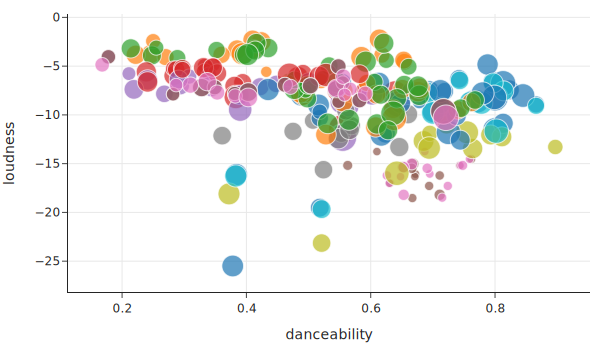

In [73]:
fig = px.scatter(clash_df, x='danceability', y='loudness', 
           color='album_name', size='duration_ms',
           width=600, height=350)

fig.update_layout(showlegend=False)
fig

This section talked about REST APIs, which provide standardized approaches for programs to download data. The example shown here downloaded JSON data. At other times, the data from a REST request may be in an XML format.
And, sometimes a REST API isn't available for the data we want, and we must extract data from web pages themselves, in HTML, a format similar to XML.
We describe how to work with these formats next.
